In [1]:
import os

os.environ["TPU_CHIPS_PER_HOST_BOUNDS"] = "1,1,1"
os.environ["TPU_HOST_BOUNDS"] = "1,1,1"
# Different per process:
os.environ["TPU_VISIBLE_DEVICES"] = "1"

# Hard EM - VAE: Fashion MNIST

In this notebook, we test the effectiveness and speed of hard-EM applied to a factor analysis and homoskedastic encoder.

We test this notebook considering an adam optimiser for both the VAE and the E and M steps of DLM hard EM.

In [2]:
import jax
import hlax
import optax
import numpy as np
import pandas as pd
import flax.linen as nn
import jax.numpy as jnp
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from functools import partial
from flax.core import freeze, unfreeze
from flax.training.train_state import TrainState
from torchvision.datasets import FashionMNIST

In [3]:
%config InlineBackend.figure_format = "retina"
%load_ext autoreload
%autoreload 2
jnp.set_printoptions(suppress=True, precision=5, linewidth=120)

## Create train dataset

In [4]:
n_train = 5_000
n_test = 1_000
train, test = hlax.datasets.load_fashion_mnist(n_train, n_test)
X_train, X_test = train[0], test[0]
num_train, dim_obs = X_train.shape

In [5]:
X_train.shape

(5000, 784)

## Setup

In [6]:
key = jax.random.PRNGKey(314)
key_vae, key_hard_em, key_test = jax.random.split(key, 3)

In [7]:
dim_latent = 50
n_epochs = 1_000

# VAE 

In [8]:
class Encoder(nn.Module):
    """
    For the inference model p(z|x)
    """
    latent_dim: int
    n_hidden: int = 5
    
    @nn.compact
    def __call__(self, x):
        z = nn.Dense(self.n_hidden)(x)
        z = nn.relu(z)
        z = nn.Dense(self.n_hidden)(z)
        z = nn.relu(z)
        mean_z = nn.Dense(self.latent_dim)(z)
        logvar_z = nn.Dense(self.latent_dim)(z)
        return mean_z, logvar_z

In [9]:
key_params_init, key_eps_init, key_train = jax.random.split(key_vae, 3)

In [10]:
batch_size = 200
n_hidden = 50
batch_init = jnp.ones((batch_size, dim_obs))

Decoder = hlax.models.DiagDecoder
model = hlax.models.VAE_IW(dim_latent, dim_obs, Encoder, Decoder)

params_init = model.init(key_params_init, batch_init, key_eps_init, num_samples=3)

In [11]:
tx = optax.adam(1e-3)
state = TrainState.create(
    apply_fn=partial(model.apply, num_samples=10),
    params=params_init,
    tx=tx
)

In [12]:
keys_train = jax.random.split(key_train, n_epochs)
hist_vae_loss = []

loss_old = -jnp.inf

for e, keyt in (pbar := tqdm(enumerate(keys_train), total=len(keys_train))):
    loss, state = hlax.vae.train_epoch(keyt, state, X_train, batch_size)

    hist_vae_loss.append(loss)        
    pbar.set_description(f"{loss=:.3e}")
    
params_vae = state.params
params_decoder_vae = freeze({"params": unfreeze(params_vae)["params"]["decoder"]})

  0%|          | 0/1000 [00:00<?, ?it/s]

In [13]:
hist_vae_mll = -jnp.array(hist_vae_loss)

# Hard EM LVM

In [14]:
%%time

# decoder = hlax.models.HomkDecoder(dim_obs, dim_latent)
decoder = hlax.models.DiagDecoder(dim_obs, dim_latent)
lossfn = hlax.hard_decoder.loss_hard_nmll

tx_params = optax.adam(1e-3)
tx_latent = optax.adam(1e-3)

key_init, key_step = jax.random.split(key_hard_em)

states = hlax.hard_decoder.initialise_state(key, decoder, tx_params,
                                            tx_latent, X_train, dim_latent)
opt_states, target_states = states
params_decoder_hem, z_decoder = target_states

 
n_its_params, n_its_latent = 5, 20
hist_hem_loss = []
for e in tqdm(range(n_epochs)):
    res = hlax.hard_decoder.train_epoch_adam(key_step, params_decoder_hem, z_decoder,
                                        opt_states, X_train, batch_size, decoder, tx_params, tx_latent,
                                        n_its_params, n_its_latent, lossfn)
    nll, params_decoder_hem, z_decoder, opt_states = res
    hist_hem_loss.append(nll)
    print(f"{nll:0.4e}", end="\r")

  0%|          | 0/1000 [00:00<?, ?it/s]

CPU times: user 48 s, sys: 13.5 s, total: 1min 1s
Wall time: 31.9 s


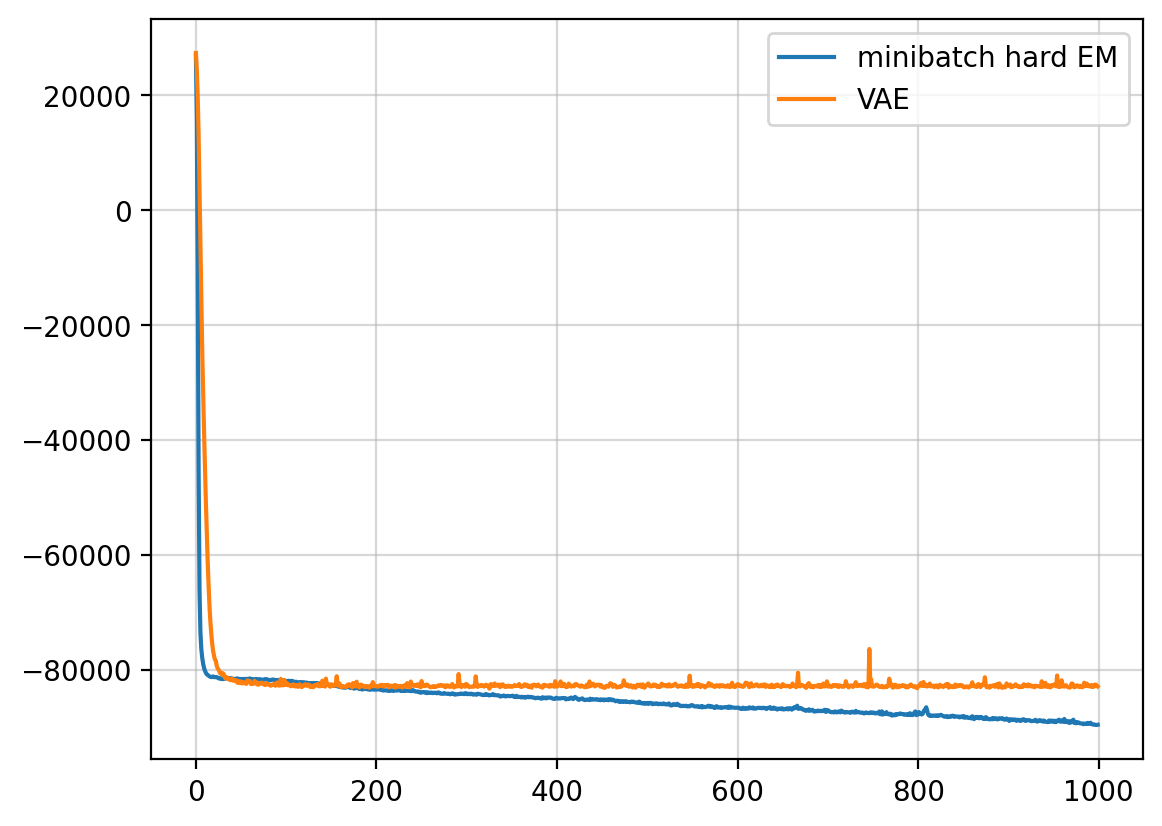

In [15]:
plt.plot(hist_hem_loss, label="minibatch hard EM")
plt.plot(hist_vae_loss, label="VAE")
plt.legend()
plt.grid(alpha=0.5)

# Fitting a distribution $q_n$ given $\boldsymbol\theta$

In this section, we find a variational distribution $q_n$ for $\boldsymbol\theta_\text{vae}$ and $\boldsymbol\theta_\text{hard-em}$. We consider a dataset ${\bf X}_\text{test}$ and train an unamortised variational distribution of the form

$$
    q_n(z_n) = \mathcal{N}(z_n \vert \mu_n, \sigma_n)
$$

In [16]:
num_is_samples = 20
num_test_epochs = 10_000
tx_test = optax.adam(1e-4)
q_encoder = hlax.models.GaussEncoder(dim_latent)

In [17]:
vae_res = hlax.training.train_encoder(key_test, X_test, q_encoder, decoder,
                                      params_decoder_vae, tx_test, num_test_epochs,
                                      num_is_samples)

hem_res = hlax.training.train_encoder(key_test, X_test, q_encoder, decoder,
                                      params_decoder_hem, tx_test, num_test_epochs,
                                      num_is_samples)

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

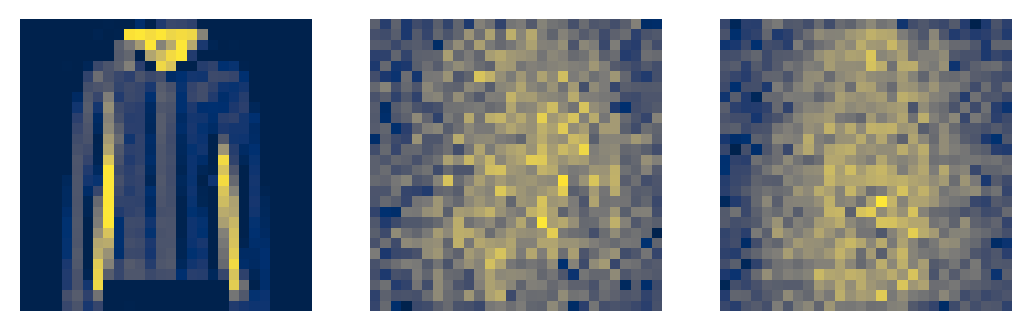

In [18]:
fig, ax = plt.subplots(1, 3)

ix = 6

z_latent =  vae_res["params"]["params"]["mu"][ix]
x_rec_vae = decoder.apply(params_decoder_vae, z_latent)[0].reshape(28, 28).to_py()

z_latent = hem_res["params"]["params"]["mu"][ix]
x_rec_hem = decoder.apply(params_decoder_hem, z_latent)[0].reshape(28, 28).to_py()

ax[0].imshow(X_test[ix].reshape(28, 28), cmap="cividis")
ax[1].imshow(x_rec_vae, cmap="cividis")
ax[2].imshow(x_rec_hem, cmap="cividis")

for axi in ax:
    axi.axis("off")

# Comparing negative IWMLL

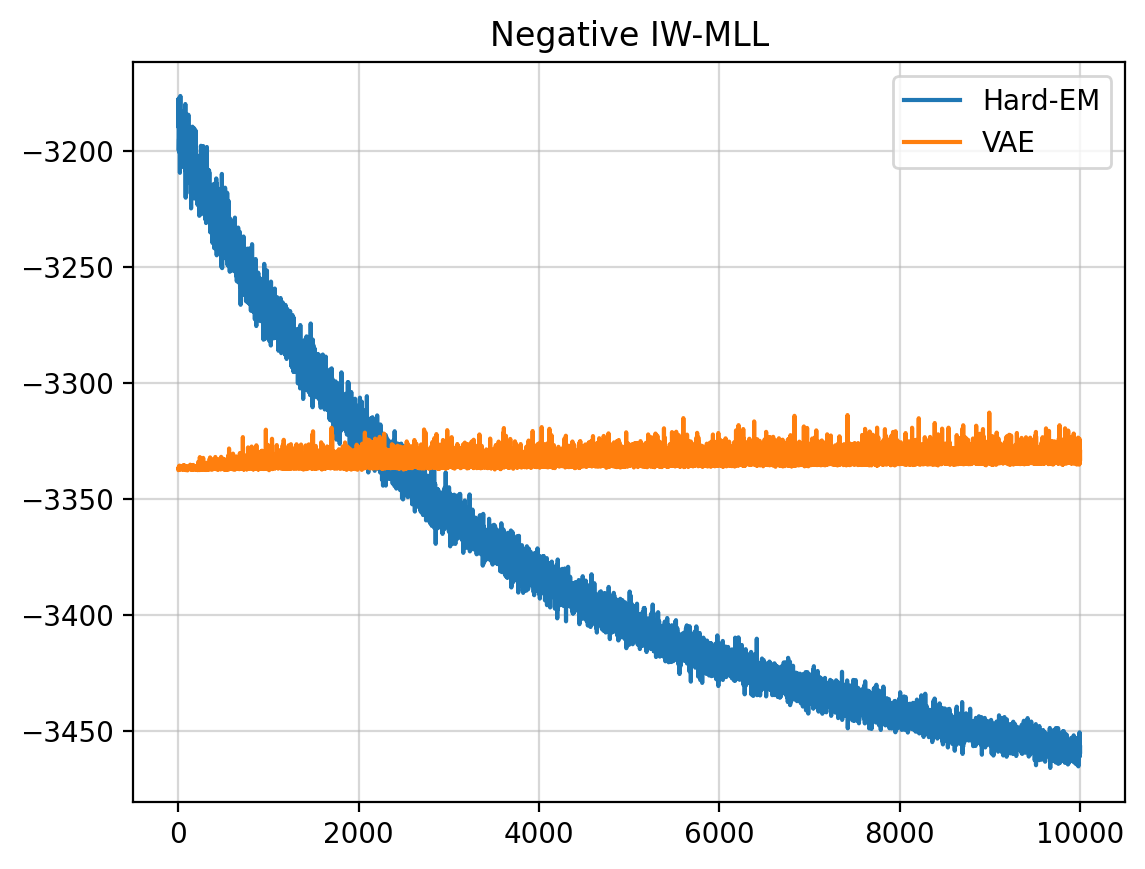

In [19]:
plt.plot(np.array(hem_res["neg_mll"]), label="Hard-EM")
plt.plot(np.array(vae_res["neg_mll"]), label="VAE")
plt.legend()
plt.title("Negative IW-MLL")
plt.grid(alpha=0.5)

In [20]:
keys_test = jax.random.split(key_test, len(X_test))
vmap_neg_iwmll = jax.vmap(hlax.training.neg_iwmll, (0, 0, None, 0, None, None, None))

In [21]:
mll_vae = -vmap_neg_iwmll(keys_test, vae_res["params"], params_decoder_vae, X_test, q_encoder, decoder, 50)
mll_hem = -vmap_neg_iwmll(keys_test, hem_res["params"], params_decoder_hem, X_test, q_encoder, decoder, 50)

In [22]:
mll_vae.mean().item(), mll_hem.mean().item()

(3335.758056640625, 3524.91748046875)

In [23]:
res = pd.DataFrame(np.c_[mll_hem, mll_vae], columns=["H-EM", "VAE"])

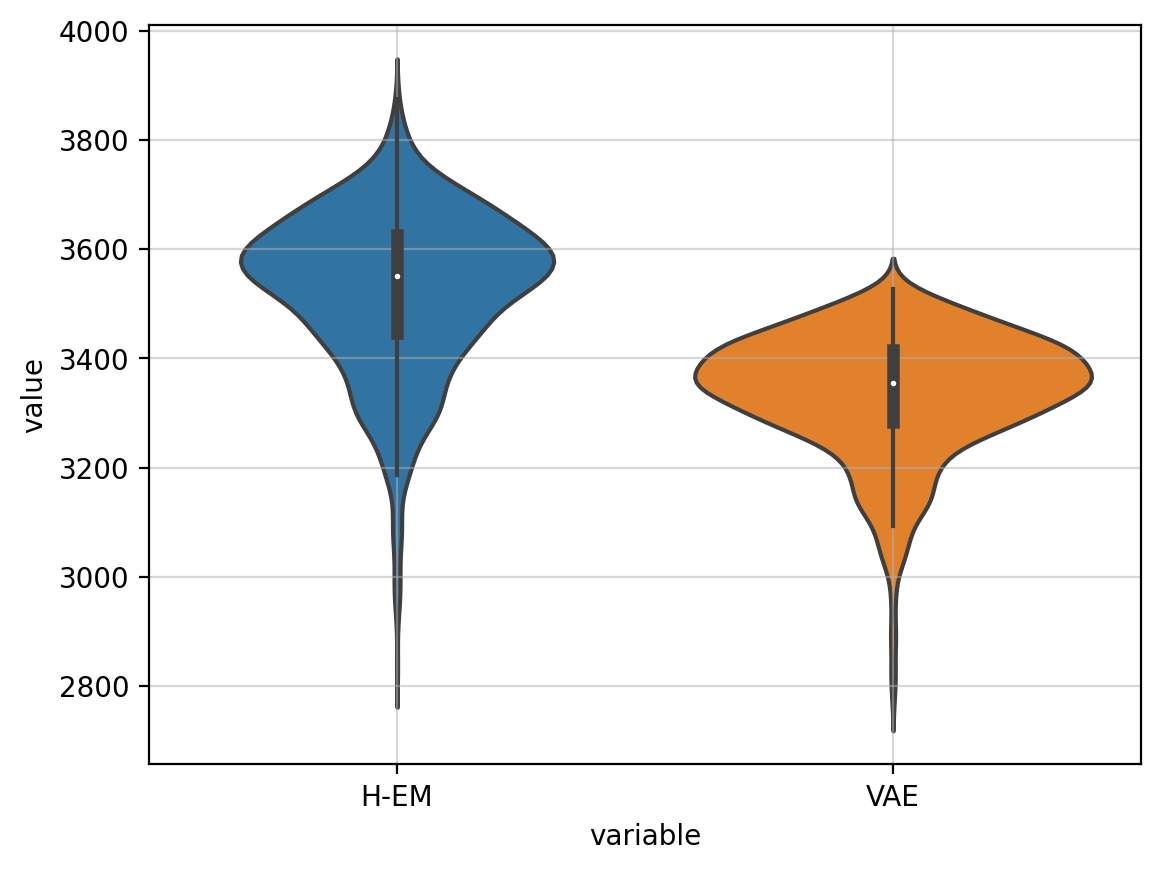

In [24]:
sns.violinplot(res.melt(), x="variable", y="value")
plt.grid(alpha=0.5)